# Preprocessing Glioblastoma Data
In this notebook, I preprocess the original glioblastoma gene expression for 200 patients to be in the correct format for me to use. That means, I have to derive a csv table with the genes as rows and the patient samples as columns.
However, I first have to join the two different dataframes (the gene expression data was delivered as two separate files) and convert the affymatrix IDs to Ensembl IDs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import mygene
import h5py
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Read the Gene Expression

In [2]:
ge1 = pd.read_csv('GSE4271-GPL96_series_matrix.txt',
                  sep='\t', quoting=csv.QUOTE_NONE,
                  comment='!', skiprows=85, encoding='utf-8')
ge1.columns = [x.strip('"') for x in ge1.columns] # remove quotes around column names
ge1['ID_REF'] = ge1['ID_REF'].map(lambda x: x.strip('"'))

In [3]:
ge2 = pd.read_csv('GSE4271-GPL97_series_matrix.txt',
                  sep='\t', quoting=csv.QUOTE_NONE,
                  comment='!', skiprows=84, encoding='utf-8')
ge2.columns = [x.strip('"') for x in ge2.columns] # remove quotes around column names
ge2['ID_REF'] = ge2['ID_REF'].map(lambda x: x.strip('"'))

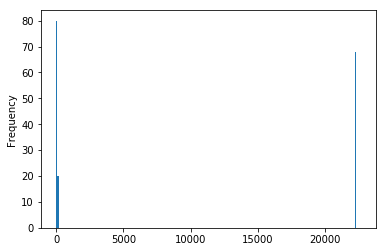

In [4]:
pd.Series(ge1[ge1.ID_REF.isin(ge2.ID_REF)].index).plot('hist', bins=np.arange(0,
                                                                              max(ge1.shape[0], ge2.shape[0]),
                                                                              100)
                                                      )

## 2. Convert Affymatrix IDs to Ensembl-IDs

In [8]:
# read conversion tables (exported from R hgu133a.db, hgu133b.db)
# these are two tables which map the Affymatrix probes to ensembl ids
mapping_a = pd.read_csv('hgu133a_to_ensembl.csv', names=['num', 'probe_id', 'ensembl_id'], header=0)
mapping_a.set_index('probe_id', inplace=True)
mapping_a.drop('num', axis=1, inplace=True)

mapping_b = pd.read_csv('hgu133b_to_ensembl.csv', names=['num', 'probe_id', 'ensembl_id'], header=0)
mapping_b.set_index('probe_id', inplace=True)
mapping_b.drop('num', axis=1, inplace=True)

# join mappings with gene expression
ge1_with_ens = ge1.join(mapping_a, on='ID_REF')
ge1_with_ens.dropna(inplace=True)

ge2_with_ens = ge2.join(mapping_b, on='ID_REF')
ge2_with_ens.dropna(inplace=True)

# set index of both data sets to ensembl id for easy joining
ge1_with_ens.set_index('ensembl_id', inplace=True)
ge2_with_ens.set_index('ensembl_id', inplace=True)

# join
gene_expression = ge1_with_ens.join(ge2_with_ens, lsuffix='l_', how='outer')
gene_expression.drop('ID_REFl_', axis=1, inplace=True)
num_genes_with_full_expr = gene_expression[~gene_expression.isnull().any(axis=1)].shape[0]
num_of_total_samples = ge1.shape[1] + ge2.shape[1]
print ("Got full expression ({} samples) for {} genes".format(num_of_total_samples,
                                                              num_genes_with_full_expr))
print ("Got any expression for {} genes".format(gene_expression.shape[0]))

# clean the data and make it nice
gene_expression.fillna(value=0, inplace=True)
gene_expression.drop('ID_REF', axis=1, inplace=True)

Got full expression (202 samples) for 12167 genes
Got any expression for 35514 genes


In [9]:
# use mygene to get ensembl IDs for the affymatrix genes
def add_ids_to_ge(ge):
    mg = mygene.MyGeneInfo()
    res = mg.querymany(pd.unique(ge.ID_REF),
                       scopes='all',
                       fields='ensembl.gene, symbol',
                       species='human', returnall=True
                      )

    # now, retrieve the names and IDs from a dictionary and put in DF
    def get_name_and_id(x):
        ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
        affy = x['query']
        name = x['symbol']
        return [affy, ens_id, name]

    ens_ids = [get_name_and_id(x) for x in res['out'] if 'ensembl' in x]
    gene_affy_ens = pd.DataFrame(ens_ids, columns=['affy_ID', 'Ensembl_ID', 'Name'])
    gene_affy_ens.set_index('affy_ID', inplace=True)
    gene_affy_ens = gene_affy_ens[~gene_affy_ens.index.duplicated(keep='first')]

    # join with node list to have the correct order and derive gene names
    gene_affy_ens = ge.join(gene_affy_ens, on='ID_REF')
    print ("{} gene names (symbols) mapped successfully".format(len(ens_ids)))
    return gene_affy_ens

In [10]:
#ge1 = add_ids_to_ge(ge1)
#ge2 = add_ids_to_ge(ge2)
#ge1.set_index('Ensembl_ID', inplace=True)
#ge2.set_index('Ensembl_ID', inplace=True)

## 3. Load PPI network and match features with it

In [22]:
data_file = '../data/cancer/hotnet_iref_vec_input_unbalanced.h5'

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [24]:
# first, bring node names to DF
nodes_df = pd.DataFrame(node_names, columns=['ensembl_id', 'name'])
nodes_df.set_index('ensembl_id', inplace=True)

# clean gene expression
gene_expression = gene_expression[~gene_expression.index.duplicated()] # remove duplicate IDs
ge_occuring_in_net = gene_expression[gene_expression.index.isin(nodes_df.index)] # remove IDs not present in network

# build feature matrix using reindexing
features_df = ge_occuring_in_net.reindex(index=nodes_df.index)
num_of_zero_nodes = features_df.isnull().any(axis=1).sum()
print ("{} out of {} nodes don't have any gene expression".format(num_of_zero_nodes, network.shape[0]))

# put 0 for missing data
features_df.fillna(0, inplace=True)

1259 out of 12129 nodes don't have any gene expression


## 4. Write out HDF5 container with feature vector

In [36]:
features = features_df.as_matrix()
string_dt = h5py.special_dtype(vlen=str)

# determine file name by parameters
fname = '../data/cancer/glioblastoma_iref_unbalanced.h5'
f = h5py.File(fname, 'w')

# add ppi network
f.create_dataset('network', data=network, shape=network.shape)

# add features
f.create_dataset('features', data=features, shape=features.shape)
# add gene names (same order as features & network)
f.create_dataset('gene_names', data=node_names, dtype=string_dt)
# add labels
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if y_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if y_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.close()
print ("Container written to {}".format(fname))

(12129, 200)
Container written to ../data/cancer/glioblastoma_iref_unbalanced.h5
